In [1]:
# now let's define dataset
import os,json
import numpy as np
import torchvision
import pdb

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, ann_file, processor, train=True):
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # can add data augmentation here before passing them to the next step
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target converting target to DETR format
        # resizing + normalization of both image and target
        
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() 
        target = encoding["labels"][0]

        return pixel_values, target
    
import transformers
processor = transformers.DetrImageProcessor.from_pretrained('facebook/detr-resnet-50')
train_dataset = CocoDetection(img_folder = './', 
                           ann_file = 'hagrid_coco_format/train.json',
                           processor = processor)
val_dataset   = CocoDetection(img_folder = './', 
                           ann_file = 'hagrid_coco_format/test.json',
                           processor = processor)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/home/leondong/miniconda3/envs/notebook/lib/python3.8/site-packages/transformers/models/detr/image_processing_detr.py:776: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


Image #4705


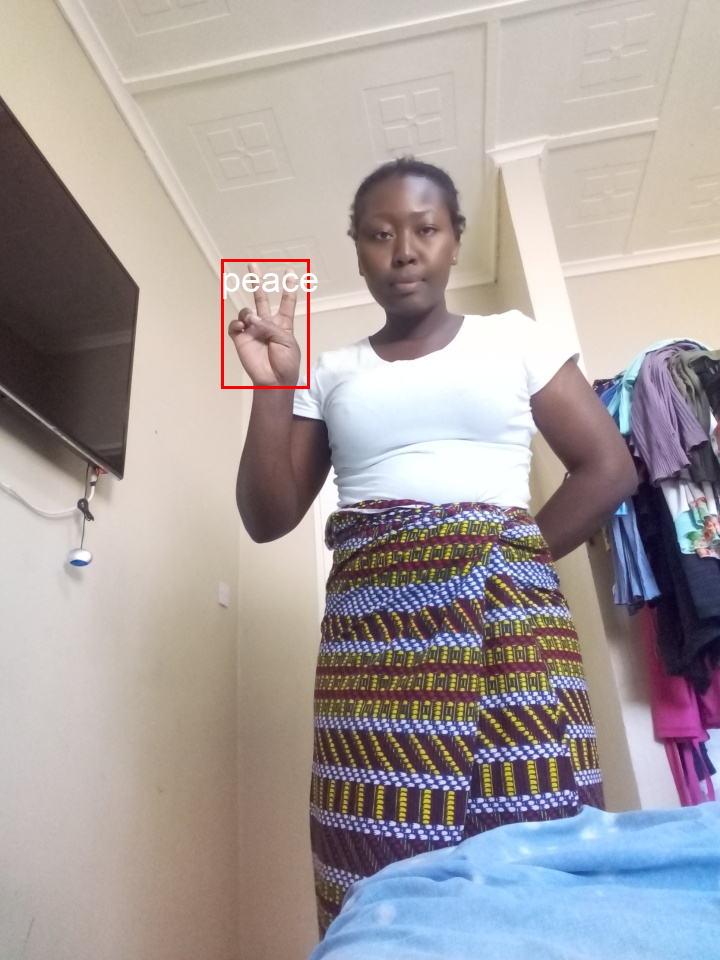

Image #729


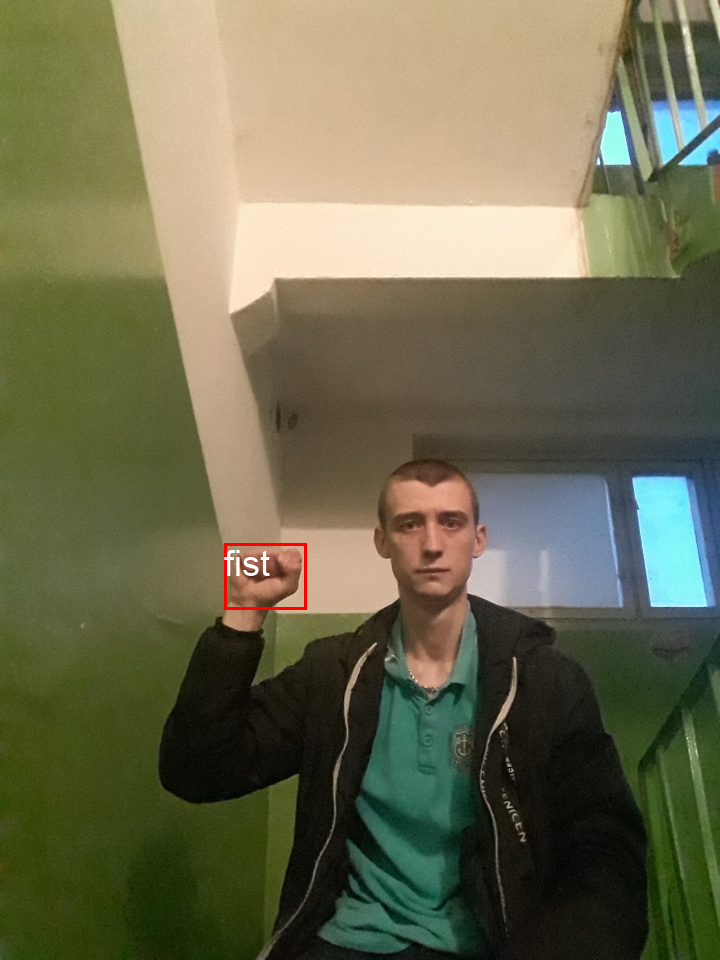

Image #4002


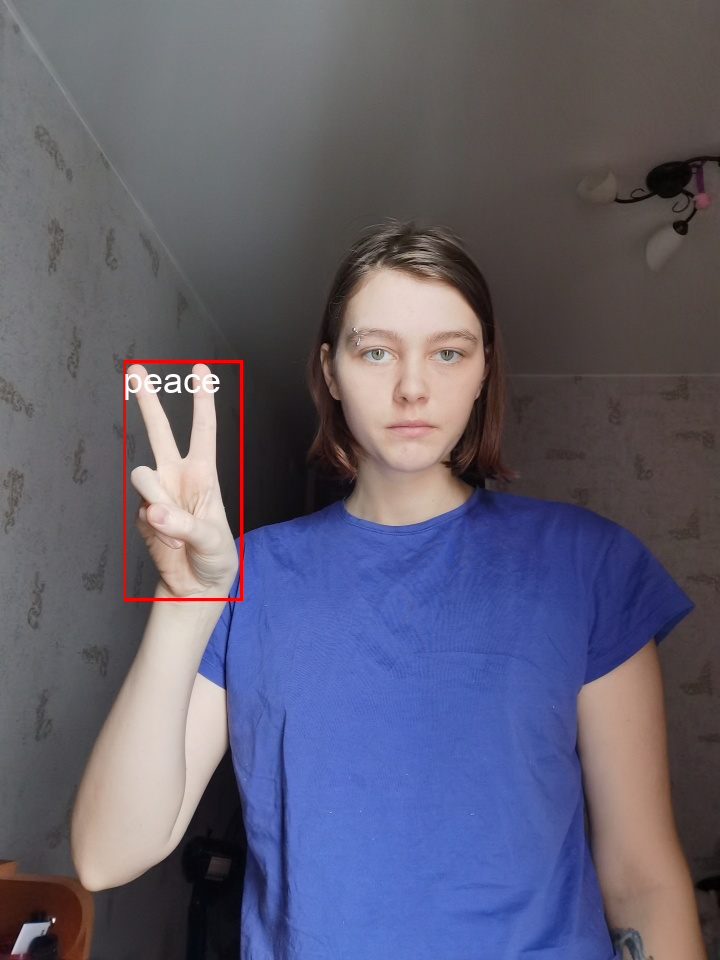

In [2]:
# let's visualize 3 images and its corresponding label

from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

image_ids = train_dataset.coco.getImgIds()
for _ in range(3):
    image_id = image_ids[np.random.randint(0, len(image_ids))]
    print('Image #{}'.format(image_id))
    image = train_dataset.coco.loadImgs(image_id)[0]
    image = Image.open( image['file_name'] )

    annotations = train_dataset.coco.imgToAnns[image_id]
    draw = ImageDraw.Draw(image, "RGBA")

    cats = train_dataset.coco.cats
    id2label = {k: v['name'] for k,v in cats.items()}
    
    font = ImageFont.truetype("arial.ttf", 36)
    for annotation in annotations:
        box = annotation['bbox']
        class_idx = annotation['category_id']
        x,y,w,h = tuple(box)
        draw.rectangle((x,y,x+w,y+h), outline='red', width = 3)
        draw.text((x, y), id2label[class_idx], fill='white', font = font)
    display(image)

In [3]:
# now define the dataloader
from torch.utils.data import DataLoader

def collate_func(batch):
    pixel_values = [item[0] for item in batch]
    encoding = processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    
    batch = {}
    batch['pixel_values'] = encoding['pixel_values']
    batch['pixel_mask'] = encoding['pixel_mask']
    batch['labels'] = labels
    return batch


train_dataloader = DataLoader(train_dataset, collate_fn=collate_func, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_func, batch_size=2)


model = transformers.DetrForObjectDetection.from_pretrained('facebook/detr-resnet-50',
                                                             num_labels = len(id2label),
                                                           ignore_mismatched_sizes=True)
print('done')

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


done


In [4]:
train_args = transformers.TrainingArguments(
    output_dir = './models/',
    num_train_epochs = 35,
    evaluation_strategy="no",
    learning_rate = 1e-3,
    logging_steps = 500,
    weight_decay = 1e-4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4
)

train_args._n_gpu = 1

trainer = transformers.Trainer(
    model = model, 
    args = train_args,
    train_dataset = train_dataset,
    data_collator = collate_func
)

trainer.train(resume_from_checkpoint=True)

/home/leondong/miniconda3/envs/notebook/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5700
  Num Epochs = 10
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 14250
  Number of trainable parameters = 41287691
/home/leondong/miniconda3/envs/notebook/lib/python3.8/site-packages/transformers/models/detr/image_processing_detr.py:882: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


Saving model checkpoint to ./models/checkpoint-500
Configuration saved in ./models/checkpoint-500/config.json
Model weights saved in ./models/checkpoint-500/pytorch_model.bin
/home/leondong/miniconda3/envs/notebook/lib/python3.8/site-packages/transformers/models/detr/image_processing_detr.py:882: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
Saving model checkpoint to ./models/checkpoint-1000
Configuration saved in ./models/checkpoint-1000/config.json
Model weights saved in ./models/checkpoint-1000/pytorch_model.bin
/home/leondong/miniconda3/envs/notebook/lib/python3.8/site-packages/transformers/models/detr/image_processing_detr.py:882: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
Saving model checkpoint to ./models/checkpoint-1500
Configuration saved in ./models/checkpoint-1500

Model weights saved in ./models/checkpoint-9500/pytorch_model.bin
/home/leondong/miniconda3/envs/notebook/lib/python3.8/site-packages/transformers/models/detr/image_processing_detr.py:882: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
Saving model checkpoint to ./models/checkpoint-10000
Configuration saved in ./models/checkpoint-10000/config.json
Model weights saved in ./models/checkpoint-10000/pytorch_model.bin
/home/leondong/miniconda3/envs/notebook/lib/python3.8/site-packages/transformers/models/detr/image_processing_detr.py:882: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
Saving model checkpoint to ./models/checkpoint-10500
Configuration saved in ./models/checkpoint-10500/config.json
Model weights saved in ./models/checkpoint-10500/pytorch_model.bin
/home/leondong/miniconda

TrainOutput(global_step=14250, training_loss=1.2393926787794682, metrics={'train_runtime': 14998.8188, 'train_samples_per_second': 3.8, 'train_steps_per_second': 0.95, 'total_flos': 4.8881896648534204e+19, 'train_loss': 1.2393926787794682, 'epoch': 10.0})

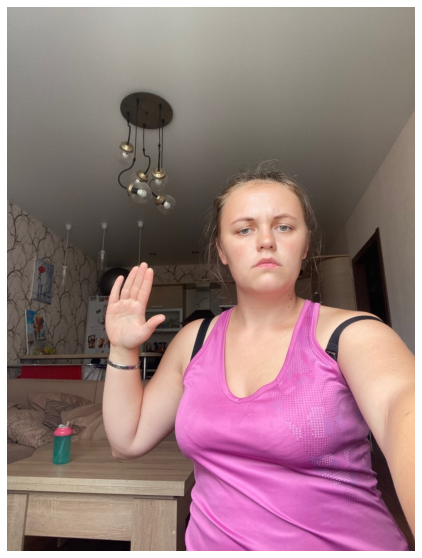

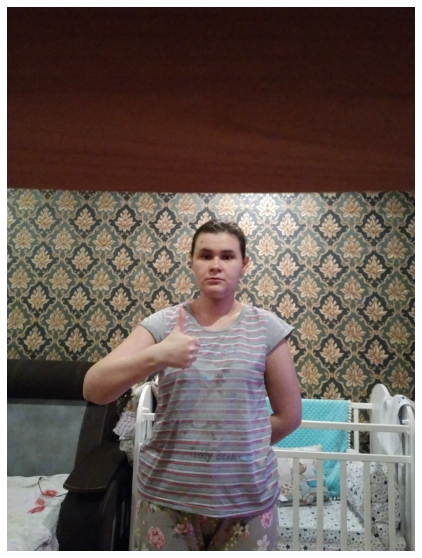

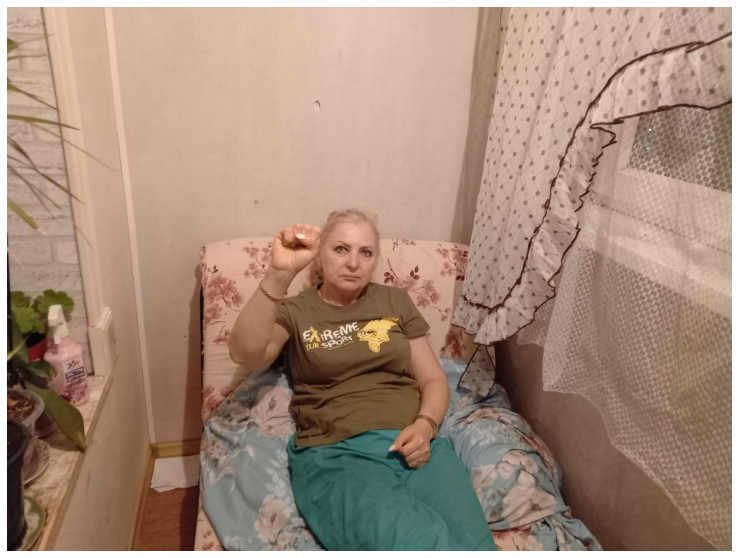

In [17]:
# visualize prediction results on validation dataset 
import torch 
from itertools import cycle 

colors = ['red', 'green','blue']
device = 'cuda:0'

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    
    iter_items = zip(scores.tolist(), labels.tolist(), boxes.tolist(), cycle(colors) )
    for score, label, (xmin, ymin, xmax, ymax), c in iter_items:
        
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        
        text = f'{id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()


model.eval()
model.to(device)

selected = np.random.choice(len(val_dataset), size = 3, replace = False)
for ind in selected:
    pixel, target = val_dataset[ind]
    pixel = pixel.unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(pixel_values = pixel, pixel_mask = None)
        
    imgid = target['image_id'].item()
    image = val_dataset.coco.loadImgs(imgid)[0]
    image = Image.open( image['file_name'] )    
    w,h = image.size 
    
    target_size = torch.tensor( [(h,w)], device = device)
    post_output = processor.post_process_object_detection(outputs,
                                                        target_sizes=target_size,
                                                        threshold=0.5)
    results = post_output[0]
    plot_results(image, results['scores'], results['labels'], results['boxes'])
    
        

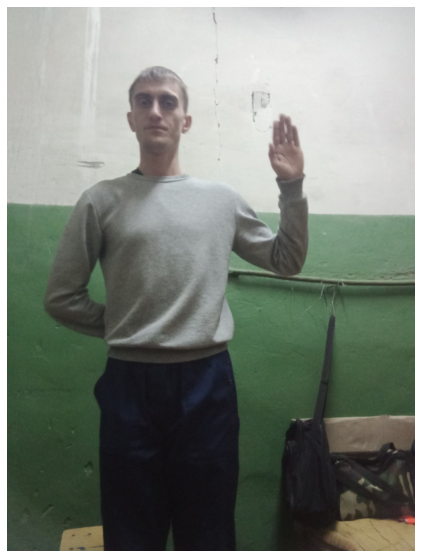

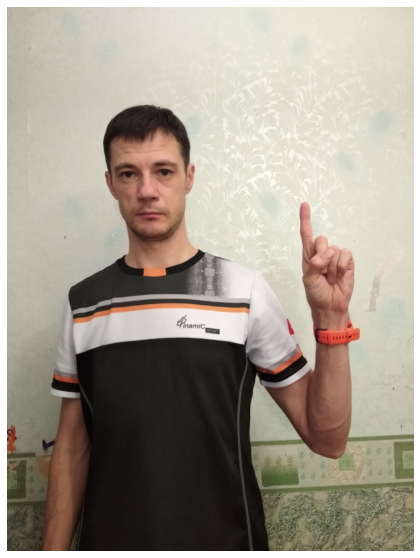

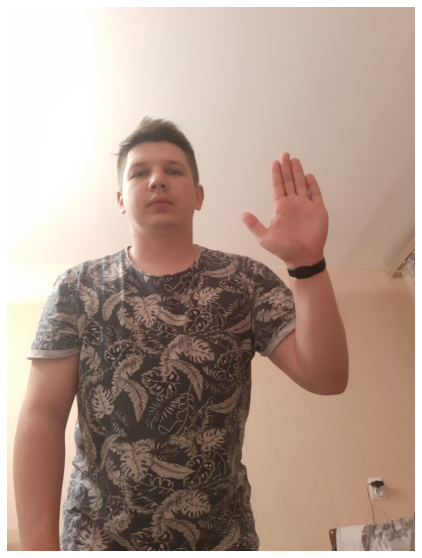

In [18]:
# test on training set as well

selected = np.random.choice(len(train_dataset), size = 3, replace = False)
for ind in selected:
    pixel, target = train_dataset[ind]
    pixel = pixel.unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(pixel_values = pixel, pixel_mask = None)
        
    imgid = target['image_id'].item()
    image = train_dataset.coco.loadImgs(imgid)[0]
    image = Image.open( image['file_name'] )    
    w,h = image.size 
    
    target_size = torch.tensor( [(h,w)], device = device)
    post_output = processor.post_process_object_detection(outputs,
                                                        target_sizes=target_size,
                                                        threshold=0.5)
    results = post_output[0]
    plot_results(image, results['scores'], results['labels'], results['boxes'])
    
        

# prevent from running following block again, if you need to run, comment the following line 
import non_exists_module

# this block preprocess data and split data into train and test
import json, os, cv2 
import numpy as np
from glob import glob

DOWN_SAMPLE = True
source_dir = './hagrid/'
output_dir = './output/'

splits = [('train', 950), ('test', 50)]
classes = ['stop', 'fist', 'one', 'peace', 'like' ,'ok']

n_splits = len(splits)
n_img = sum([item[1] for item in splits])
np.random.seed(3)

for label in classes:
    print(f'Working on {label}......')
    with open(f'./{source_dir}/annotations/{label}.json') as f:
        anno_info = json.load(f)
        
    all_imgs = glob(f'{source_dir}/imgs/{label}/*.jpg')
    all_ids = [item.split('/')[-1][:-4] for item in all_imgs]
    selected = np.random.choice(len(all_ids), size = n_img, replace = False)
    
    i = 0
    for phase, size in splits:
        img_dir = f'{output_dir}/imgs/{phase}/{label}/'
        anno_dir = f'{output_dir}/annotations/ann_{phase}/'
        os.makedirs(img_dir, exist_ok = True)
        os.makedirs(anno_dir, exist_ok = True)
        
        anno = {}
        j = i+size
        for k in range(i,j):
            imgid = all_ids[ selected[k] ]  
            anno[imgid] = anno_info[imgid]
            
            if not DOWN_SAMPLE:
                os.system(f'cp {all_imgs[selected[k]]} {img_dir}')
            else:
                img = cv2.imread(all_imgs[selected[k]])
                h,w = img.shape[:2]
                img = cv2.resize(img, [w//2, h//2])
                cv2.imwrite(f'{img_dir}/{imgid}.jpg', img)
                
        
        with open(f'{anno_dir}/{label}.json', 'w+') as f:
            json.dump(anno, f)
        i = j


# now let's convert the format into coco format using provided scripts 
output_dir = './output/'

converter_config = '''
dataset:
  dataset_annotations: {}/annotations/
  dataset_folder: {}/imgs/
  phases: [train, test] 
  targets:
    - fist
    - like
    - ok
    - one
    - peace
    - stop
'''.format(output_dir, output_dir)

with open('convert_conf.yaml', 'w+') as f:
    f.write(converter_config)
    
! python hagrid_to_coco.py --cfg convert_conf.yaml 